<a href="https://colab.research.google.com/github/NathanyApSalles/analysis_foodtech/blob/main/Case_Tecnico_DataAnalyst_Ifood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bases

In [1]:
import requests
import tarfile
import os
from pyspark.sql import SparkSession, DataFrame

spark = SparkSession.builder.getOrCreate()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import shapiro, anderson, boxcox, mannwhitneyu
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [56]:
from   sklearn.cluster import KMeans
from   sklearn.metrics import silhouette_score, silhouette_samples

In [3]:
def read_file(url: str, local_path: str, type_file: str) -> DataFrame:
  """Função para ler arquivo e retornar um Dataframe."""
  if not os.path.exists(local_path):
    response = requests.get(url)
    with open(local_path, "wb") as f:
        f.write(response.content)
  if type_file == "json":
    return spark.read.json(local_path, multiLine=False)
  elif type_file == "csv":
    return spark.read.option("header", "true").csv(local_path)
  elif type_file == "tar":

    arquivos_extraidos = "/tmp/ab_test_ref"

    os.makedirs(arquivos_extraidos, exist_ok=True)

    with tarfile.open(local_path, "r:gz") as tar:
        tar.extractall(path=arquivos_extraidos)

    filename = ""
    for root, dirs, files in os.walk(arquivos_extraidos):
        for filename in files:
            print(filename) # print para visualizar todos os arquivos exraídos
    if ".csv" in filename: # se houver algum arquivo csv, junte todos os arquivos deste tipo no dataframe
      return spark.read.option("header", "true").csv(arquivos_extraidos + "/*.csv")
    else: # se houver algum arquivo json, junte todos os arquivos deste tipo no dataframe
      return spark.read.json(arquivos_extraidos + "/*.json")
      #pode acontecer de ter arquivos de diferentes tipos misturados, mas para este estudo vamos assumir que todos são do mesmo tipo


In [4]:
url_pedidos = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz"
url_usuarios = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz"
url_merchants = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz"
url_test_ab = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"

local_path_pedidos = "/tmp/order.json.gz"
local_path_usuarios = "/tmp/consumer.csv.gz"
local_path_merchants = "/tmp/restaurant.csv.gz"
local_path_teste_ab = "/tmp/ab_test_ref.tar.gz"

pedidos = read_file(url_pedidos, local_path_pedidos, "json").cache()
usuarios = read_file(url_usuarios, local_path_usuarios, "csv").cache()
merchants = read_file(url_merchants, local_path_merchants, "csv").cache()
teste_ab = read_file(url_test_ab, local_path_teste_ab, "tar").cache()

._ab_test_ref.csv
ab_test_ref.csv


In [5]:
pedidos.show(5)

+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+--

In [6]:
usuarios.show(5)

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05T14:49:...|  true|         NUNO|                 46|            816135924|
|a2834a38a9876cf74...|   pt-br|2018-01-14T21:40:...|  true|     ADRIELLY|                 59|            231330577|
|41e1051728eba1334...|   pt-br|2018-01-07T03:47:...|  true|        PAULA|                 62|            347597883|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10T22:17:...|  true|       HELTON|                 13|            719366842|
|7823d4cf4150c5dae...|   pt-br|2018-04-06T00:16:...|  true|       WENDER|                 76|            543232158|
+--------------------+--------+--------------------+------+-------------

In [7]:
merchants.show(5)

+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|                  id|          created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code| merchant_city|merchant_state|merchant_country|
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|d19ff6fca6288939b...|2017-01-23T12:52:...|  false|          3|          60.0|           0|           50|               30.0|            14025|RIBEIRAO PRETO|            SP|              BR|
|631df0985fdbbaf27...|2017-01-20T13:14:...|   true|          3|          60.0|           0|            0|               30.0|            50180|     SAO PAULO|            SP|              BR|
|135c5c4ae4c1ec1fd...|2017-01-23T12:46:...|  

In [8]:
teste_ab.show(5, truncate=False)

+----------------------------------------------------------------+---------+
|customer_id                                                     |is_target|
+----------------------------------------------------------------+---------+
|755e1fa18f25caec5edffb188b13fd844b2af8cf5adedcf77c028f36cb9382ea|target   |
|b821aa8372b8e5b82cdc283742757df8c45eecdd72adf411716e710525d4edf1|control  |
|d425d6ee4c9d4e211b71da8fc60bf6c5336b2ea9af9cc007f5297541ec40b63b|control  |
|6a7089eea0a5dc294fbccd4fa24d0d84a90c1cc12e829c8b535718bbc651ab02|target   |
|dad6b7e222bab31c0332b0ccd9fa5dbd147008facd268f5e3763fa657c23a58d|control  |
+----------------------------------------------------------------+---------+
only showing top 5 rows



In [9]:
from pyspark.sql.functions import col, broadcast, when, count, isnan, count_distinct, sum, avg, row_number, lag, date_diff, round, max, to_date, lit
from pyspark.sql.window import Window

# Entendendo os dados

In [10]:
def df_info(df: DataFrame, colunas: list) -> None:
  """Função para auxiliar a identificar tamanho da base, tipo das colunas,
   valores nulos, duplicidade em colunas específicas na base."""
  # validando o tipo das colunas
  df.printSchema()

  # validando o tamanho da base
  print(f"Qtd de linhas: {df.count()}")

  print("\nValores nulos")
  df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

  print("\nValidando valores duplicados")
  for column in colunas:
    num_duplicados = df.groupBy(column).count().where(col("count") > 1).count()
    print(f"\n{column}: {num_duplicados}")

In [11]:
df_info(usuarios, ["customer_id"])

root
 |-- customer_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- active: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_phone_area: string (nullable = true)
 |-- customer_phone_number: string (nullable = true)

Qtd de linhas: 806156

Valores nulos
+-----------+--------+----------+------+-------------+-------------------+---------------------+
|customer_id|language|created_at|active|customer_name|customer_phone_area|customer_phone_number|
+-----------+--------+----------+------+-------------+-------------------+---------------------+
|          0|       0|         0|     0|            0|                  0|                    0|
+-----------+--------+----------+------+-------------+-------------------+---------------------+


Validando valores duplicados

customer_id: 0


In [12]:
df_info(pedidos, ["order_id"])

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: string (nullable = true)
 |--

In [13]:
# removendo os usuários nulos da base
# na base de pedidos temos um número pequeno de pedidos sem customer_id atribuído,
# porém como o objetivo da análise é validar os resultados do teste a/b, estes pedidos serão removidos visto que
# não participaram do teste a/b
pedidos_validos_ab = pedidos.where(col("customer_id").isNotNull())

In [14]:
# podemos ver que a base de pedidos possui uma grande voliumentria de pedidos duplicados
# foi analisado uma amostra e notou-se que para os pedidos duplicados, os campos que diferente são CPF e data de criação do pedido
# pode ter acontecido algum problema no produto ao gerar o número do pedido, ou até mesmo ao gerar a base,
# diantes disto podemos seguir com algumas tratativas, como criar um novo order_id concatenando com o CPF, ou
# dentro dos duplicados manter o pedido mais atual, ou a mais antigo.
# Como os valores dos pedidos são iguais, merchants, itens também são idênticos, optou-se por manter o pedido mais antigo


pedidos_validos_ab = (pedidos_validos_ab
                      .withColumn("rank", row_number().over(Window.partitionBy("order_id").orderBy("order_created_at")))
                      .where(col("rank") == 1)
                      .drop("rank")
).cache()
df_info(pedidos_validos_ab, ["order_id"])

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: string (nullable = true)
 |--

In [15]:
df_info(merchants, ["id"])

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- enabled: string (nullable = true)
 |-- price_range: string (nullable = true)
 |-- average_ticket: string (nullable = true)
 |-- takeout_time: string (nullable = true)
 |-- delivery_time: string (nullable = true)
 |-- minimum_order_value: string (nullable = true)
 |-- merchant_zip_code: string (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- merchant_country: string (nullable = true)

Qtd de linhas: 7292

Valores nulos
+---+----------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+-------------+--------------+----------------+
| id|created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code|merchant_city|merchant_state|merchant_country|
+---+----------+-------+-----------+--------------+------------+-------------+-------------------+---

In [16]:
df_info(teste_ab, ["customer_id"])

root
 |-- customer_id: string (nullable = true)
 |-- is_target: string (nullable = true)

Qtd de linhas: 806467

Valores nulos
+-----------+---------+
|customer_id|is_target|
+-----------+---------+
|          0|        0|
+-----------+---------+


Validando valores duplicados

customer_id: 0


# EDA

In [17]:
# tem no teste_Ab mas não comprou? ou seja, não está na base de pedidos?
c = pedidos_validos_ab.select(col("customer_id").alias("custumer_with_order")).distinct()
teste_ab.join(c, col("customer_id") == col("custumer_with_order"), "left").where(col("custumer_with_order").isNull()).show()

+-----------+---------+-------------------+
|customer_id|is_target|custumer_with_order|
+-----------+---------+-------------------+
|       null|   target|               NULL|
+-----------+---------+-------------------+



# Sugestão de Teste A/B
- Todos os usuários do teste a/b tem algum pedido, logo, uma sugestão é ter uma base sobre todas os usuários que receberam cupons para conseguirmos calcular conversão;
- Teste com diferentes valores de cupons para entender se o valor do desconto impacta no ticket médio;
- Frete grátis: entender se cupons de frete grátis aumentam o ticket médio;
- Avaliar base de de satisfação (NPS) para entender se a disponibilização de cupons impactam na experiencia e satisfação do usuário;
- Carrinho abandonado: teste a/b de envio de cupons para usuários que abandonaram carrinho e analisar a finalização da compra (conversão). Aplicável principalmente para usuários de produtos de farmácia e mercado, visto que a compra de refeições é feita por usuários que já esperam uma entrega rápida.

In [18]:
teste_ab.groupBy(col("is_target")).agg(count_distinct("customer_id")).show()

+---------+---------------------------+
|is_target|count(DISTINCT customer_id)|
+---------+---------------------------+
|  control|                     360542|
|   target|                     445925|
+---------+---------------------------+



In [19]:
pedidos_final = pedidos_validos_ab.join(broadcast(teste_ab), ['customer_id'], "left").cache()
#pedidos_final.show(5)

In [20]:
#pedidos_final.where(col("is_target").isNull()).show()

In [21]:
pedidos_final.groupBy(col("is_target")).agg(
                                      count_distinct(col("order_id")).alias("distinct_orders"),
                                      count_distinct(col("customer_id")).alias("distinct_customers"),
                                      count_distinct(col("merchant_id")).alias("distinct_merchants"),
                                      sum(col("order_total_amount")).alias("order_total_amount"),
                                      avg(col("order_total_amount")).alias("order_avg_amount"),
                                      (sum(col("order_total_amount"))/count_distinct(col("order_id"))).alias("ticket_medio"),


                                      ).show()

+---------+---------------+------------------+------------------+-------------------+-----------------+-----------------+
|is_target|distinct_orders|distinct_customers|distinct_merchants| order_total_amount| order_avg_amount|     ticket_medio|
+---------+---------------+------------------+------------------+-------------------+-----------------+-----------------+
|  control|        1010738|            360542|              7196|4.843220348999915E7|47.91766361806833|47.91766361806833|
|   target|        1416677|            445924|              7227| 6.77299864499999E7|47.80905347513929|47.80905347513929|
+---------+---------------+------------------+------------------+-------------------+-----------------+-----------------+



# tempo entre compras

In [22]:
df = pedidos_final.withColumn("data_criacao_pedido", col("order_created_at").cast("date")).select("customer_id", "is_target", "data_criacao_pedido")

df_tempo_entre_compras = df.withColumn("data_pedido_anterior", lag("data_criacao_pedido") \
                                       .over(Window.partitionBy("customer_id").orderBy("data_criacao_pedido"))) \
                            .withColumn("tempo_entre_compras", date_diff("data_criacao_pedido", "data_pedido_anterior"))

df_tempo_entre_compras.show()

+--------------------+---------+-------------------+--------------------+-------------------+
|         customer_id|is_target|data_criacao_pedido|data_pedido_anterior|tempo_entre_compras|
+--------------------+---------+-------------------+--------------------+-------------------+
|00006f567cb362ba9...|   target|         2019-01-01|                NULL|               NULL|
|00006f567cb362ba9...|   target|         2019-01-01|          2019-01-01|                  0|
|00006f567cb362ba9...|   target|         2019-01-02|          2019-01-01|                  1|
|00006f567cb362ba9...|   target|         2019-01-03|          2019-01-02|                  1|
|00006f567cb362ba9...|   target|         2019-01-24|          2019-01-03|                 21|
|0000bb10fb47a1d6b...|  control|         2018-12-21|                NULL|               NULL|
|0000bb10fb47a1d6b...|  control|         2018-12-21|          2018-12-21|                  0|
|0000c21984ae00cef...|  control|         2018-12-13|        

In [23]:
tempo_medio_entre_compras = df_tempo_entre_compras.where(col("tempo_entre_compras").isNotNull()).groupBy("is_target").agg(avg("tempo_entre_compras"))
tempo_medio_entre_compras.show()

+---------+------------------------+
|is_target|avg(tempo_entre_compras)|
+---------+------------------------+
|  control|       7.895633009123403|
|   target|       7.901386861539444|
+---------+------------------------+



In [24]:
tempo_medio_entre_compras = df_tempo_entre_compras.groupBy("customer_id","is_target") \
.agg(round(avg("tempo_entre_compras"),2).alias("tempo_medio_entre_compras"),
     max("data_criacao_pedido").alias("data_ultima_compra")) \
.withColumn("tempo_medio_entre_compras", when(col("tempo_medio_entre_compras").isNull(), 0).otherwise(col("tempo_medio_entre_compras"))) \
.withColumn("recencia", date_diff(to_date(lit("2019-02-01")), "data_ultima_compra")) \
.drop(col("data_ultima_compra"))


tempo_medio_entre_compras.show()

+--------------------+---------+-------------------------+--------+
|         customer_id|is_target|tempo_medio_entre_compras|recencia|
+--------------------+---------+-------------------------+--------+
|00006f567cb362ba9...|   target|                     5.75|       8|
|0000bb10fb47a1d6b...|  control|                      0.0|      42|
|0000c21984ae00cef...|  control|                     2.23|       1|
|0001226e517517758...|   target|                      7.0|      48|
|00016cfde8c0af0a4...|  control|                      0.0|      12|
|000200d3759a5b4d0...|   target|                      0.0|      57|
|00021cd56b6d6c980...|   target|                     11.5|      29|
|00021f6dc15d10418...|   target|                     37.0|      16|
|0002287b123ac1afc...|   target|                      0.0|      47|
|00022b8c0c7af061f...|  control|                     3.25|      19|
|00024bc2f09ce5769...|  control|                      0.0|      33|
|00027035d16a4de43...|  control|                

In [25]:
# qtd diferente de merchants, diversificação de estabelecimentos, entender se os clientes tem algum estabelecimento onde mais compram,
# ou se compram em vários

In [39]:
frequencia_valor = pedidos_final.groupBy(col("customer_id"),col("is_target")) \
.agg(
      count_distinct(col("order_id")).alias("distinct_orders"),
      count_distinct(col("merchant_id")).alias("distinct_merchants"),
      round(sum(col("order_total_amount")),2).alias("order_total_amount"),
      round((sum(col("order_total_amount"))/count_distinct(col("order_id"))),2).alias("ticket_medio"))
frequencia_valor.show()

+--------------------+---------+---------------+------------------+------------------+------------+
|         customer_id|is_target|distinct_orders|distinct_merchants|order_total_amount|ticket_medio|
+--------------------+---------+---------------+------------------+------------------+------------+
|ddfdc1202bd21b07d...|  control|             18|                 7|            551.32|       30.63|
|ed858ee2b8b73a5c4...|  control|             32|                16|           1999.03|       62.47|
|bc03f83da6b98b509...|  control|              5|                 4|            245.11|       49.02|
|756a01d9c11d4affc...|  control|              1|                 1|              52.0|        52.0|
|04edd62e53c0b1700...|  control|              1|                 1|              48.0|        48.0|
|2ede26bdea707c792...|   target|              9|                 7|            508.55|       56.51|
|70388a43322330ac9...|  control|              2|                 2|             68.47|       34.24|


In [41]:
perfil_compra = tempo_medio_entre_compras.alias("t") \
.join(frequencia_valor.alias("f"), ["customer_id"], "inner") \
.withColumn("is_target_dummy", when(col("t.is_target") == "target", lit(1)).otherwise(lit(0))) \
.select("t.customer_id",
        "is_target_dummy",
        "tempo_medio_entre_compras",
        "recencia",
        "distinct_orders",
        "distinct_merchants",
        "order_total_amount",
        "ticket_medio"
        )

perfil_compra.show()

+--------------------+---------------+-------------------------+--------+---------------+------------------+------------------+------------+
|         customer_id|is_target_dummy|tempo_medio_entre_compras|recencia|distinct_orders|distinct_merchants|order_total_amount|ticket_medio|
+--------------------+---------------+-------------------------+--------+---------------+------------------+------------------+------------+
|00006f567cb362ba9...|              1|                     5.75|       8|              5|                 4|             533.1|      106.62|
|0000c21984ae00cef...|              0|                     2.23|       1|             23|                 8|           1011.36|       43.97|
|0001226e517517758...|              1|                      7.0|      48|              2|                 2|              86.5|       43.25|
|00021cd56b6d6c980...|              1|                     11.5|      29|              3|                 3|              47.8|       15.93|
|00021f6dc15d

In [44]:
pd_perfil_compra = perfil_compra.toPandas()

pd_perfil_compra["is_target_dummy"] = pd_perfil_compra["is_target_dummy"].astype("int")

In [52]:
pd_perfil_compra.columns

Index(['customer_id', 'is_target_dummy', 'tempo_medio_entre_compras',
       'recencia', 'distinct_orders', 'distinct_merchants',
       'order_total_amount', 'ticket_medio'],
      dtype='object')

Text(0.5, 1.0, 'Correlação de Pearson')

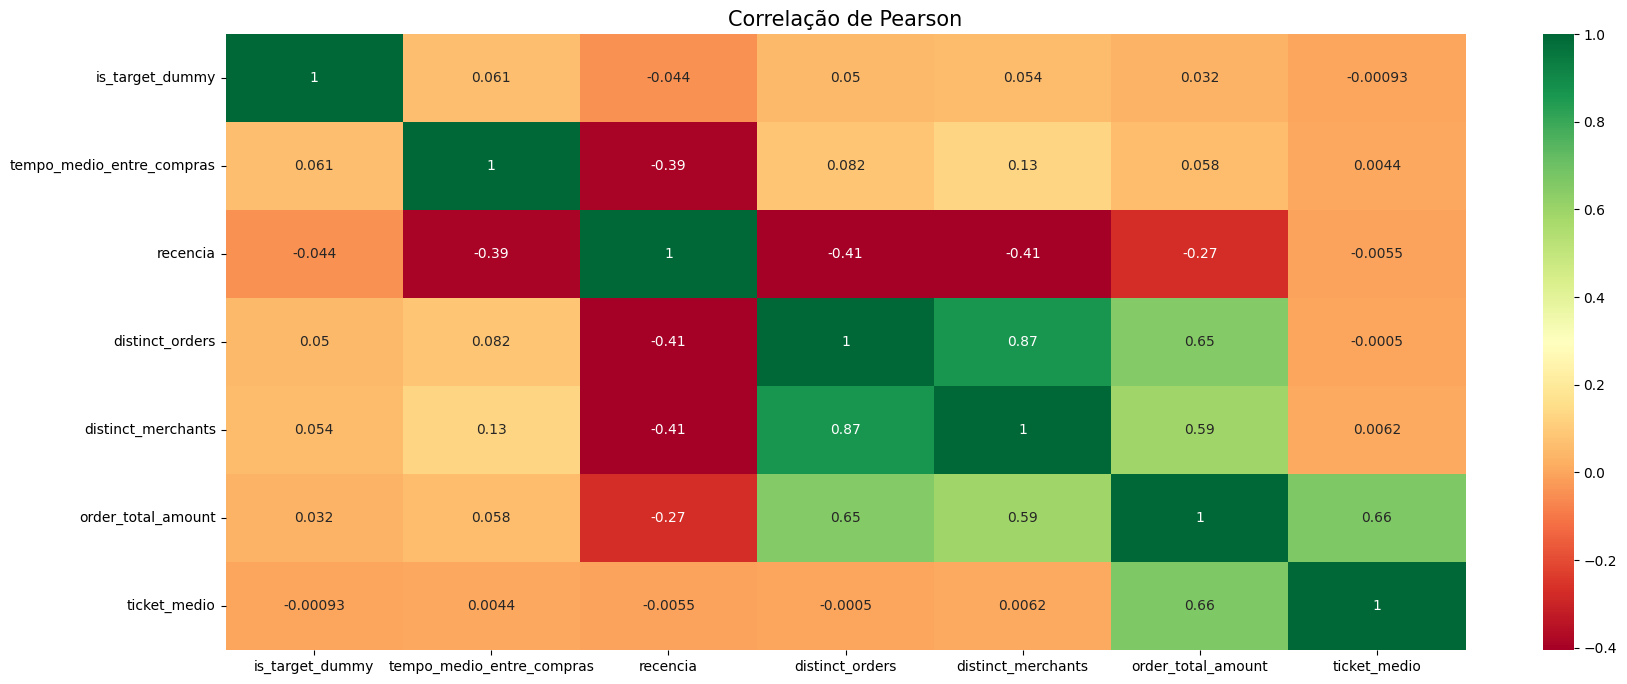

In [43]:
corr_perfil_compra = pd_perfil_compra.drop(columns=["customer_id"])

#correlação de pearson
plt.figure(figsize=(20,8))
sns.heatmap(corr_perfil_compra.corr(), annot = True, cmap = "RdYlGn");
plt.title('Correlação de Pearson', size = 15)

In [54]:
#fazendo o preprocessamento dos dados
# padronizar os dados pois os dados estão em escala diferentes, o método escolhido será MinMaxScaler, pois os dados não obedecem uma distribuição normal

#normalização das colunas numéricas
pd_perfil_compra_n = pd_perfil_compra.copy()

pd_perfil_compra_n = pd_perfil_compra_n.drop(columns=["customer_id"])

minmax = MinMaxScaler()
#transformação de cada coluna e atribuição ao novo df codificado
for column in pd_perfil_compra_n:
  pd_perfil_compra_n[column] = minmax.fit_transform(pd_perfil_compra_n[[column]])

pd_perfil_compra_n

,is_target_dummy,tempo_medio_entre_compras,recencia,distinct_orders,distinct_merchants,order_total_amount,ticket_medio
0,1.0,0.097458,0.118644,0.025641,0.088235,0.003799,0.001519
1,0.0,0.037797,0.000000,0.141026,0.205882,0.007207,0.000627
2,1.0,0.118644,0.796610,0.006410,0.029412,0.000616,0.000616
3,1.0,0.194915,0.474576,0.012821,0.058824,0.000341,0.000227
4,1.0,0.627119,0.254237,0.006410,0.029412,0.001244,0.001244
...,...,...,...,...,...,...,...
806461,1.0,0.135593,0.559322,0.012821,0.058824,0.000954,0.000636
806462,0.0,0.000000,0.372881,0.000000,0.000000,0.000353,0.000705
806463,1.0,0.067797,0.779661,0.006410,0.029412,0.000686,0.000686
806464,0.0,0.000000,0.813559,0.000000,0.000000,0.000170,0.000339


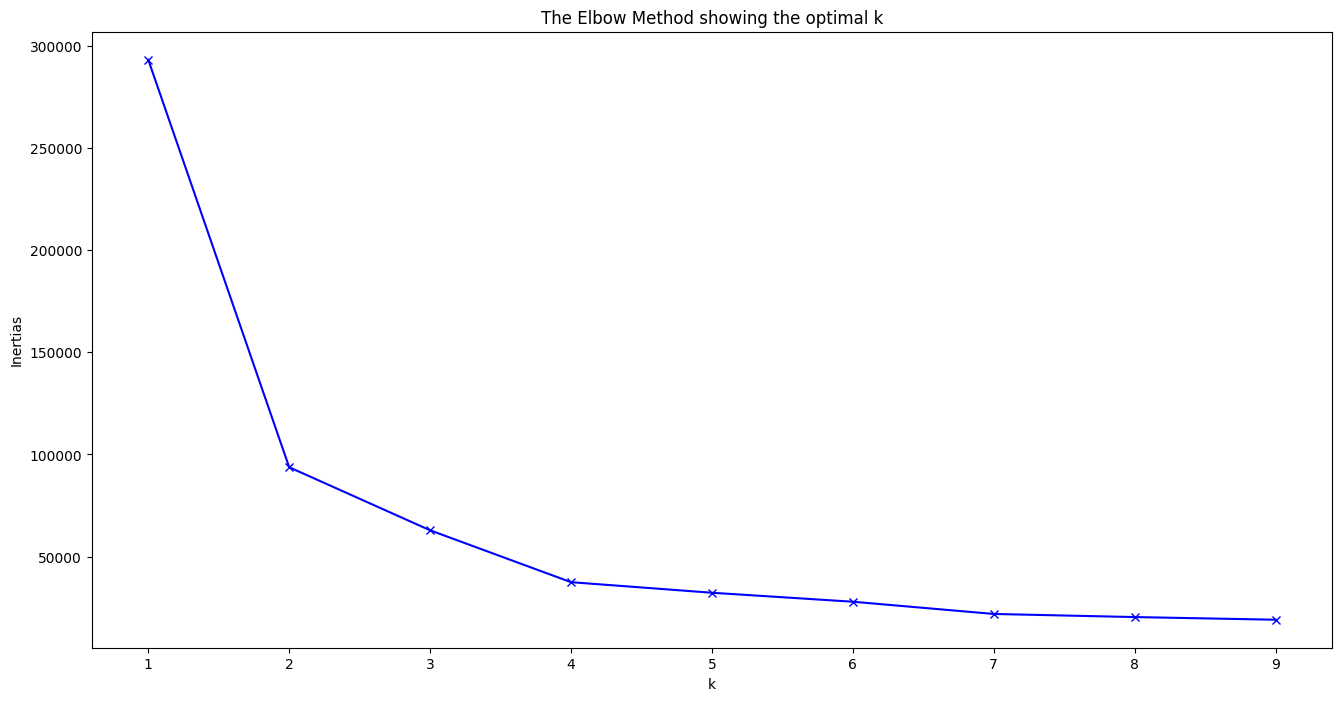

In [57]:
# elbow para ter insumos sobre a quantidade ideal de grupos
inertias = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=300, random_state=13).fit(pd_perfil_compra_n)
    inertias.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertias')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [58]:
model = KMeans(n_clusters=3).fit(pd_perfil_compra_n)
predict = model.predict(pd_perfil_compra_n)
pd_perfil_compra["Clusters"] = predict
pd_perfil_compra["Clusters"].value_counts()


,count
Clusters,
0,360542
2,261659
1,184265


In [61]:
pd_perfil_compra.groupby("Clusters")[["is_target_dummy", "tempo_medio_entre_compras", "recencia", "distinct_orders", "distinct_merchants", "order_total_amount", "ticket_medio"]].mean()


,is_target_dummy,tempo_medio_entre_compras,recencia,distinct_orders,distinct_merchants,order_total_amount,ticket_medio
Clusters,,,,,,,
0,0.0,5.742908,23.771145,2.803385,2.009530,134.331655,48.003125
1,1.0,2.272751,40.101153,1.618045,1.408515,75.528269,47.251162
2,1.0,10.245744,9.699292,4.274755,2.789210,205.659923,48.246368




---


# Teste de Hipótese:

In [ ]:
#qtd de pedidos por usuário
df_media_pedidos = pedidos_final.groupBy(col("customer_id"), col("is_target")).agg(count_distinct("order_id").alias("qtd_pedidos_por_usuario"))

df_media_pedidos.groupBy(col("is_target")).agg(avg(col("qtd_pedidos_por_usuario")).alias("media_pedidos_por_usuario")).show()

# Usuários target compram mais do que usuários control?
Primeiramente vamos validar se os dados possuem uma distribuição normal

##Teste de Shapiro Wilk

**- H0:** A amostra segue uma distribuição normal

**- H1:** A amostra não segue uma distribuição normal
- Se _p-value_ < 0.05, rejeita-se a hipótese nula, ou seja, temos evidências suficientes para dizer que a amostra não vem de distribuição normal


In [ ]:
pd_pedidos = df_media_pedidos.toPandas()

In [ ]:
# analisando se os dados obedecem uma distribuição normal
statistic, pvalue = shapiro(pd_pedidos["qtd_pedidos_por_usuario"])
print(f"statistic={statistic}, pvalue={pvalue}")
if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')

Como os dados não seguem uma distribuição normal, logo, seguiremos por testes não paramétricos

## Hipóteses
**H0:** quantidade de pedidos do grupo target é igual ao grupo control

**H1:** quantidade de pedidos do grupo target é diferente ao grupo control

In [ ]:
target = pd_pedidos[pd_pedidos["is_target"]=="target"]
control = pd_pedidos[pd_pedidos["is_target"]=="control"]

statistic, pvalue = mannwhitneyu(target["qtd_pedidos_por_usuario"], control["qtd_pedidos_por_usuario"])
print(f"statistic={statistic}, pvalue={pvalue}")

if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')

#tamanho de efeito

print(statistic/(len(target["qtd_pedidos_por_usuario"])*len(control["qtd_pedidos_por_usuario"])))

## Resultado:
Rejeitamos a hipótese nula (H₀) e aceitamos a hipótese alternativa, ou seja, há uma diferença significativa entre a quantidade de pedidos dos dois grupos. O tamanho de efeito nos informa a magnitude desta diferença, sendo um índice entre 0 e 1. O tamanho do efeito calculado é 0.55, o que sugere um efeito de tamanho moderado. Isso significa que a diferença na quantidade de pedidos é significativa além de ser relevante.


---


## Vamos analisar agora se a diferença é para mais ou para menos
**H0:** usuários do grupo target tem igual ou menor quatidade de pedidos que o contro control

**H1:** usuários do grupo target tem maior quatidade de pedidos que o contro control

In [ ]:

target = pd_pedidos[pd_pedidos["is_target"]=="target"]
control = pd_pedidos[pd_pedidos["is_target"]=="control"]

statistic, pvalue = mannwhitneyu(target["qtd_pedidos_por_usuario"], control["qtd_pedidos_por_usuario"], alternative='greater')
print(f"statistic={statistic}, pvalue={pvalue}")

if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')

#tamanho de efeito

print(statistic/(len(target["qtd_pedidos_por_usuario"])*len(control["qtd_pedidos_por_usuario"])))

## Resultado do teste de hipótese:
Novamente rejeitamos a hipótese nula (H₀) concluindo que o grupo target realizou mais pedidos em relação ao grupo control
O tamanho de efeito nos informa a magnitude desta diferença, sendo um índice entre 0 e 1. O tamanho do efeito calculado é 0.55, o que sugere um efeito de tamanho moderado. Isso significa que a diferença no tempo de atendimento é significativa além de ser relevante.



---




- tarquet x control

    - qtd de pedidos
    - valor total da compra
    - ticket médio
    - tempo entre compras
    - recorrencia
    - tem diferença entre usuários ativos ou não?
    - expansão geográfica: qtd de estabelecimentos diferentes que compraram
    - restaurantes que mais venderam
    - região que mais vendeu
    - horário das compras
    - qtd de produtos adquiridos

- ideias para teste ab:

    - qtd de usuários que receberam o cupom, para entender conversão, de quem recebeu, quem não comprou;
     